In [1]:
import warnings

warnings.filterwarnings("ignore")

import datasets as ds
import matplotlib.pyplot as plt
import numpy as np
#import optimization as opt
import sklearn.datasets as skds
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import robust_scale
from sklearn import datasets


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import torch
from numpy.linalg import norm

In [3]:
### FRIEDMAN PROBLEM

# MODELS / TRAINING
class LinearRegression(torch.nn.Module):
    """Muliple linear regression as a perceptron.
    
    Parameters
    ----------
    m_beta : int
        Numbers of beta weights.
    """
    def __init__(self, m_betas):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(m_betas, 1, bias=False)
        
    def forward(self, x):
        return self.linear(x)
    
    
class Friedman(torch.nn.Module):
    """Friedman regression as a perceptron.
    
    Parameters
    ----------
    m_beta : int
        Numbers of beta weights.
    """
    def __init__(self,x):
        
        super().__init__()
        
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))
        self.e = torch.nn.Parameter(torch.randn(()))
        
    def forward(self,x):
            
        return self.a*torch.sin(torch.pi*x[:,0]*x[:,1]) + self.b*(x[:,2]-self.c)**2 + self.d*(x[:,3]) + self.e* x[:,4]


def train_model(X, y, method='sgd', lr=0.01, n_epochs=1000, opt_kwargs=None):
    """Train various gradient descent algorithms.
    
    Parameters
    ----------
    X : 2d tensor
        Features.
    y : 1d tensor
        Target.
    method : {'sgd', 'lbfgs', 'newton'}
        Model to train.
    lr : float, optional, default: 0.01
        Learning rate (step size).
    n_epochs : int, optional, default: 1000
        Number of training iterations.
    opt_kwargs : dict, optional, default: None
        Optimizers kwargs to pass through to pytorch.
        
    Returns
    -------
    betas : 1d array
        Estimated beta parameters.
    loss_hist : 1d array
        Loss per step.
    elapsed : float
        Total time to train and run n_epochs.
    """
    
    # Initalize model and loss function
    #model = LinearRegression(len(X[0]))
    model = Friedman(X)
    loss_func = torch.nn.MSELoss()
    loss_hist = np.zeros(n_epochs)
    
    # Select optimizer
    opt_kwargs = {} if opt_kwargs is None else opt_kwargs
    if method == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, **opt_kwargs)
    elif method == 'lbfgs':
        optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, **opt_kwargs)
    elif method == 'newton':
        betas = torch.rand(X.size(1), 1)
    else:
        raise ValueError('Undefined method.')

    # Required for LBFGS
    def closure():

        # Zero gradients
        optimizer.zero_grad()
        
        # Get predicted y
        y_hat = model(X)

        # Compute loss
        loss = loss_func(y_hat, y)
        
        # Update weights
        loss.backward()
        
        return loss

    # Required for Newton's method
    def compute_loss(betas):
        #y_hat = torch.matmul(X, betas)
        y_hat = betas[0] * torch.sin(torch.pi*X[0]*X[1]) + betas[1] * (X[2] - betas[2])**2 +(betas[3]*X[3]) +(betas[4]*X[4]) # Friedman regression
        return torch.nn.MSELoss()(y_hat, y)
            
    # Train
    start = time.time()
    for i in range(n_epochs):
        
        if method == 'sgd':
            loss = closure()
            optimizer.step()
            loss_hist[i] = loss
        elif method == 'lbfgs':
            loss = optimizer.step(closure)
            loss_hist[i] = loss
        elif method == 'newton':

            # Compute gradient and Hessian
            grad = jacobian(compute_loss, betas)
            
            if X.size()[1] == 1: #check how many features
                hess = torch.zeros((1,1)) # have to make a 1x1 tensor to be in unity with other cases when m > 1
                # for some reason, hessian() output has no shape so we need to put it in the initialized 1x1 tensor
                hess[0] =  hessian(compute_loss, betas).inverse().squeeze() 
            else:
                hess = hessian(compute_loss, betas).squeeze().inverse()

            # Step
            betas = betas - torch.matmul(hess, grad)

            loss_hist[i] = compute_loss(betas)

    # Time
    end = time.time()
    elapsed = end-start
    
    if method != 'newton':
        #betas = model.linear.weight.detach()[0]
        betas = [param.data.item() for param in model.parameters()]
    else:
        betas = betas[:, 0]
        
    return betas, loss_hist, elapsed


def test_train_model():
    """Test 1 beta and 10 beta cases."""
    
    m = 100
        
    times = {}

    X, beta, y = sim_lm(m * 10, m, seed=m)

    for method in ['sgd', 'newton', 'lbfgs']:

        beta_hat, loss_hist, elapsed = train_model(X, y, method=method)

        times[method] = elapsed

        # Check convergence
        assert all(
           beta_hat.numpy().round(2) == beta.numpy().round(2)
        )

    if m == 100:
        assert times['sgd']  < times['lbfgs'] < times['newton']

def save_data(n_sim,n_epochs,noise):
    file = 'friedman_sim_data_'+'obs_'+str(n_sim)+'sims_'+str(n_epochs)+'_epochs_noise'+str(noise)+'.npz'
    np.savez(file,beta_mse = beta_mse,elapsed_time = elapsed_time,loss_history = loss_history)
# test_train_model() this is slow but passes

## Noise = 0

In [4]:
b = np.array([10,20,0.5,10,5]) # DO NOT CHANGE, THESE ARE TRUE BETAS 
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
n_epochs = 250
n_sim = 100
noise = 0
# Track loss, beta error, and elapsed time
loss_history = {
    'sgd': np.zeros((n_sim, n_epochs)),
    'lbfgs': np.zeros((n_sim, n_epochs))
}

beta_mse = {
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}

elapsed_time = {
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}



for i in tqdm(range(n_sim)): # 100 simulations take 6 minutes
    X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=noise, random_state=i)
    X_new = torch.tensor(X,requires_grad=True)
    y_new = torch.tensor(y,requires_grad=True)
    
    b_hat_sgd, loss_hist_sgd, elapsed_sgd = train_model(X_new, y_new, method='sgd', n_epochs=n_epochs)
    b_hat_lbfgs, loss_hist_lbfgs, elapsed_lbfgs = train_model(X_new, y_new, method='lbfgs', n_epochs=n_epochs)

    beta_mse['sgd'][i] = float(((b - np.array(b_hat_sgd))**2).mean())
    elapsed_time['sgd'][i] = elapsed_sgd
    loss_history['sgd'][i] = loss_hist_sgd
    
    beta_mse['lbfgs'][i] = float(((b - np.array(b_hat_lbfgs))**2).mean())
    elapsed_time['lbfgs'][i] = elapsed_lbfgs
    loss_history['lbfgs'][i] = loss_hist_lbfgs
save_data(n_sim,n_epochs,noise)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (s)')

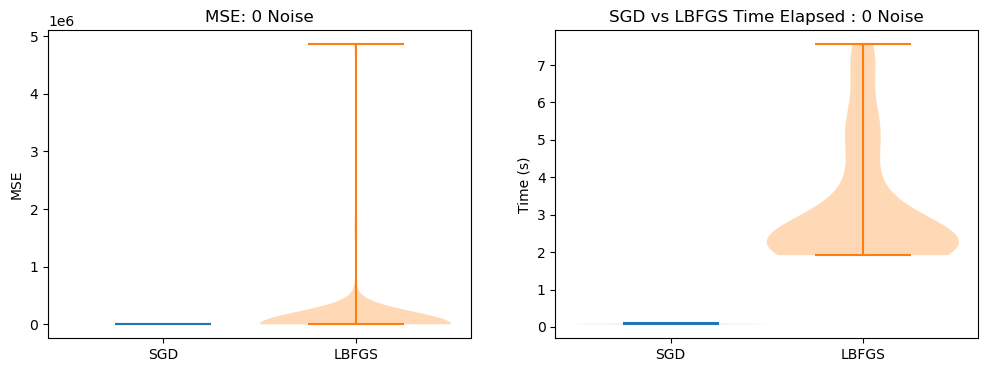

In [5]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
def get_finite_vals(array):
    ii = np.isfinite(array)
    return(array[ii])
    
axes[0].violinplot(get_finite_vals(beta_mse['sgd']))
axes[0].violinplot(get_finite_vals(beta_mse['lbfgs']), positions=[1.5])
    
axes[1].violinplot(get_finite_vals(elapsed_time['sgd']))
axes[1].violinplot(get_finite_vals(elapsed_time['lbfgs']), positions=[1.5])
    
axes[0].set_xticks([1, 1.5], ['SGD', 'LBFGS'])
axes[1].set_xticks([1, 1.5], ['SGD', 'LBFGS'])
    
axes[0].set_title(f'MSE: 0 Noise')
axes[1].set_title(f'SGD vs LBFGS Time Elapsed : 0 Noise')
    
axes[0].set_ylabel('MSE')
axes[1].set_ylabel('Time (s)')

Text(0, 0.5, 'Count')

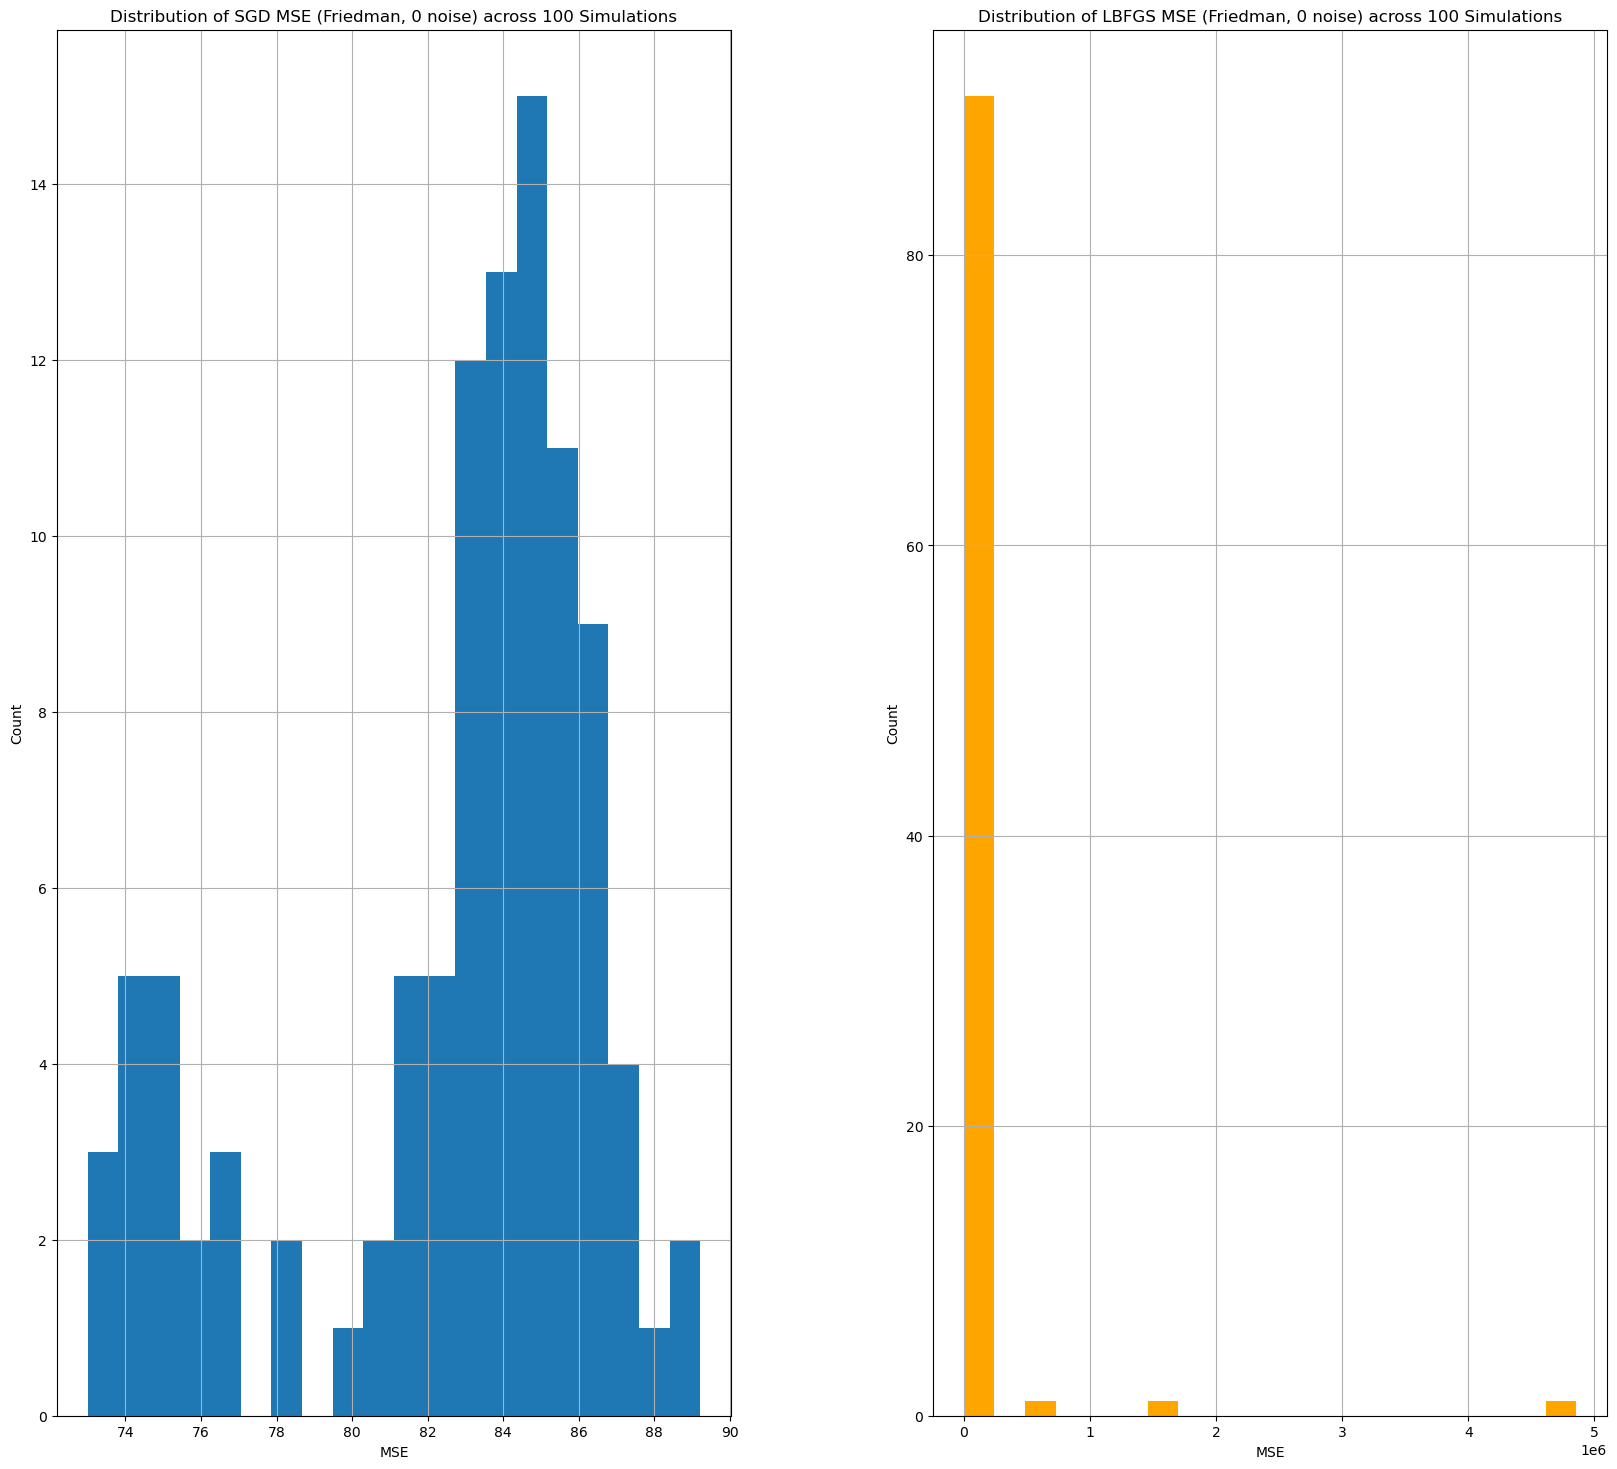

In [6]:
sgd_mse_df = pd.DataFrame(beta_mse['sgd'])
lbfgs_mse_df = pd.DataFrame(beta_mse['lbfgs'])
n = 2
fig, ax = plt.subplots(1, 2, figsize=(20, 18))
sgd_mse_df.hist(ax = ax[0],bins = 20)
ax[0].set_title('Distribution of SGD MSE (Friedman, 0 noise) across 100 Simulations')
ax[0].set_xlabel('MSE')
ax[0].set_ylabel('Count')
lbfgs_mse_df.hist(ax = ax[1], bins = 20, color = 'orange')
ax[1].set_title('Distribution of LBFGS MSE (Friedman, 0 noise) across 100 Simulations')
ax[1].set_xlabel('MSE')
ax[1].set_ylabel('Count')

## Noise = 50

In [9]:
b = np.array([10,20,0.5,10,5]) # DO NOT CHANGE, THESE ARE TRUE BETAS 
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
n_epochs = 250
n_sim = 100
noise = 50
# Track loss, beta error, and elapsed time
loss_history = {
    'sgd': np.zeros((n_sim, n_epochs)),
    'lbfgs': np.zeros((n_sim, n_epochs))
}

beta_mse = {
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}

elapsed_time = {
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}



for i in tqdm(range(n_sim)): # 100 simulations take 6 minutes
    X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=noise, random_state=i)
    X_new = torch.tensor(X,requires_grad=True)
    y_new = torch.tensor(y,requires_grad=True)
    
    b_hat_sgd, loss_hist_sgd, elapsed_sgd = train_model(X_new, y_new, method='sgd', n_epochs=n_epochs)
    b_hat_lbfgs, loss_hist_lbfgs, elapsed_lbfgs = train_model(X_new, y_new, method='lbfgs', n_epochs=n_epochs)

    beta_mse['sgd'][i] = float(((b - np.array(b_hat_sgd))**2).mean())
    elapsed_time['sgd'][i] = elapsed_sgd
    loss_history['sgd'][i] = loss_hist_sgd
    
    beta_mse['lbfgs'][i] = float(((b - np.array(b_hat_lbfgs))**2).mean())
    elapsed_time['lbfgs'][i] = elapsed_lbfgs
    loss_history['lbfgs'][i] = loss_hist_lbfgs
save_data(n_sim,n_epochs,noise)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (s)')

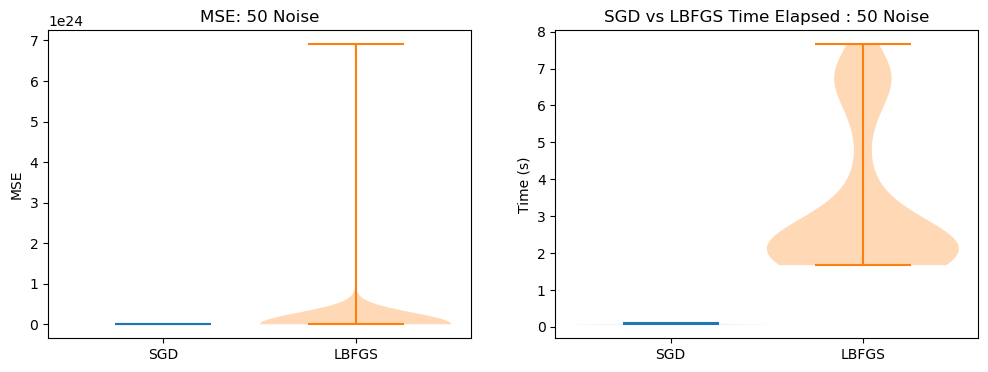

In [10]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
def get_finite_vals(array):
    ii = np.isfinite(array)
    return(array[ii])
    
axes[0].violinplot(get_finite_vals(beta_mse['sgd']))
axes[0].violinplot(get_finite_vals(beta_mse['lbfgs']), positions=[1.5])
    
axes[1].violinplot(get_finite_vals(elapsed_time['sgd']))
axes[1].violinplot(get_finite_vals(elapsed_time['lbfgs']), positions=[1.5])
    
axes[0].set_xticks([1, 1.5], ['SGD', 'LBFGS'])
axes[1].set_xticks([1, 1.5], ['SGD', 'LBFGS'])
    
axes[0].set_title(f'MSE: '+str(noise)+' Noise')
axes[1].set_title(f'SGD vs LBFGS Time Elapsed : '+str(noise)+' Noise')
    
axes[0].set_ylabel('MSE')
axes[1].set_ylabel('Time (s)')

Text(0, 0.5, 'Count')

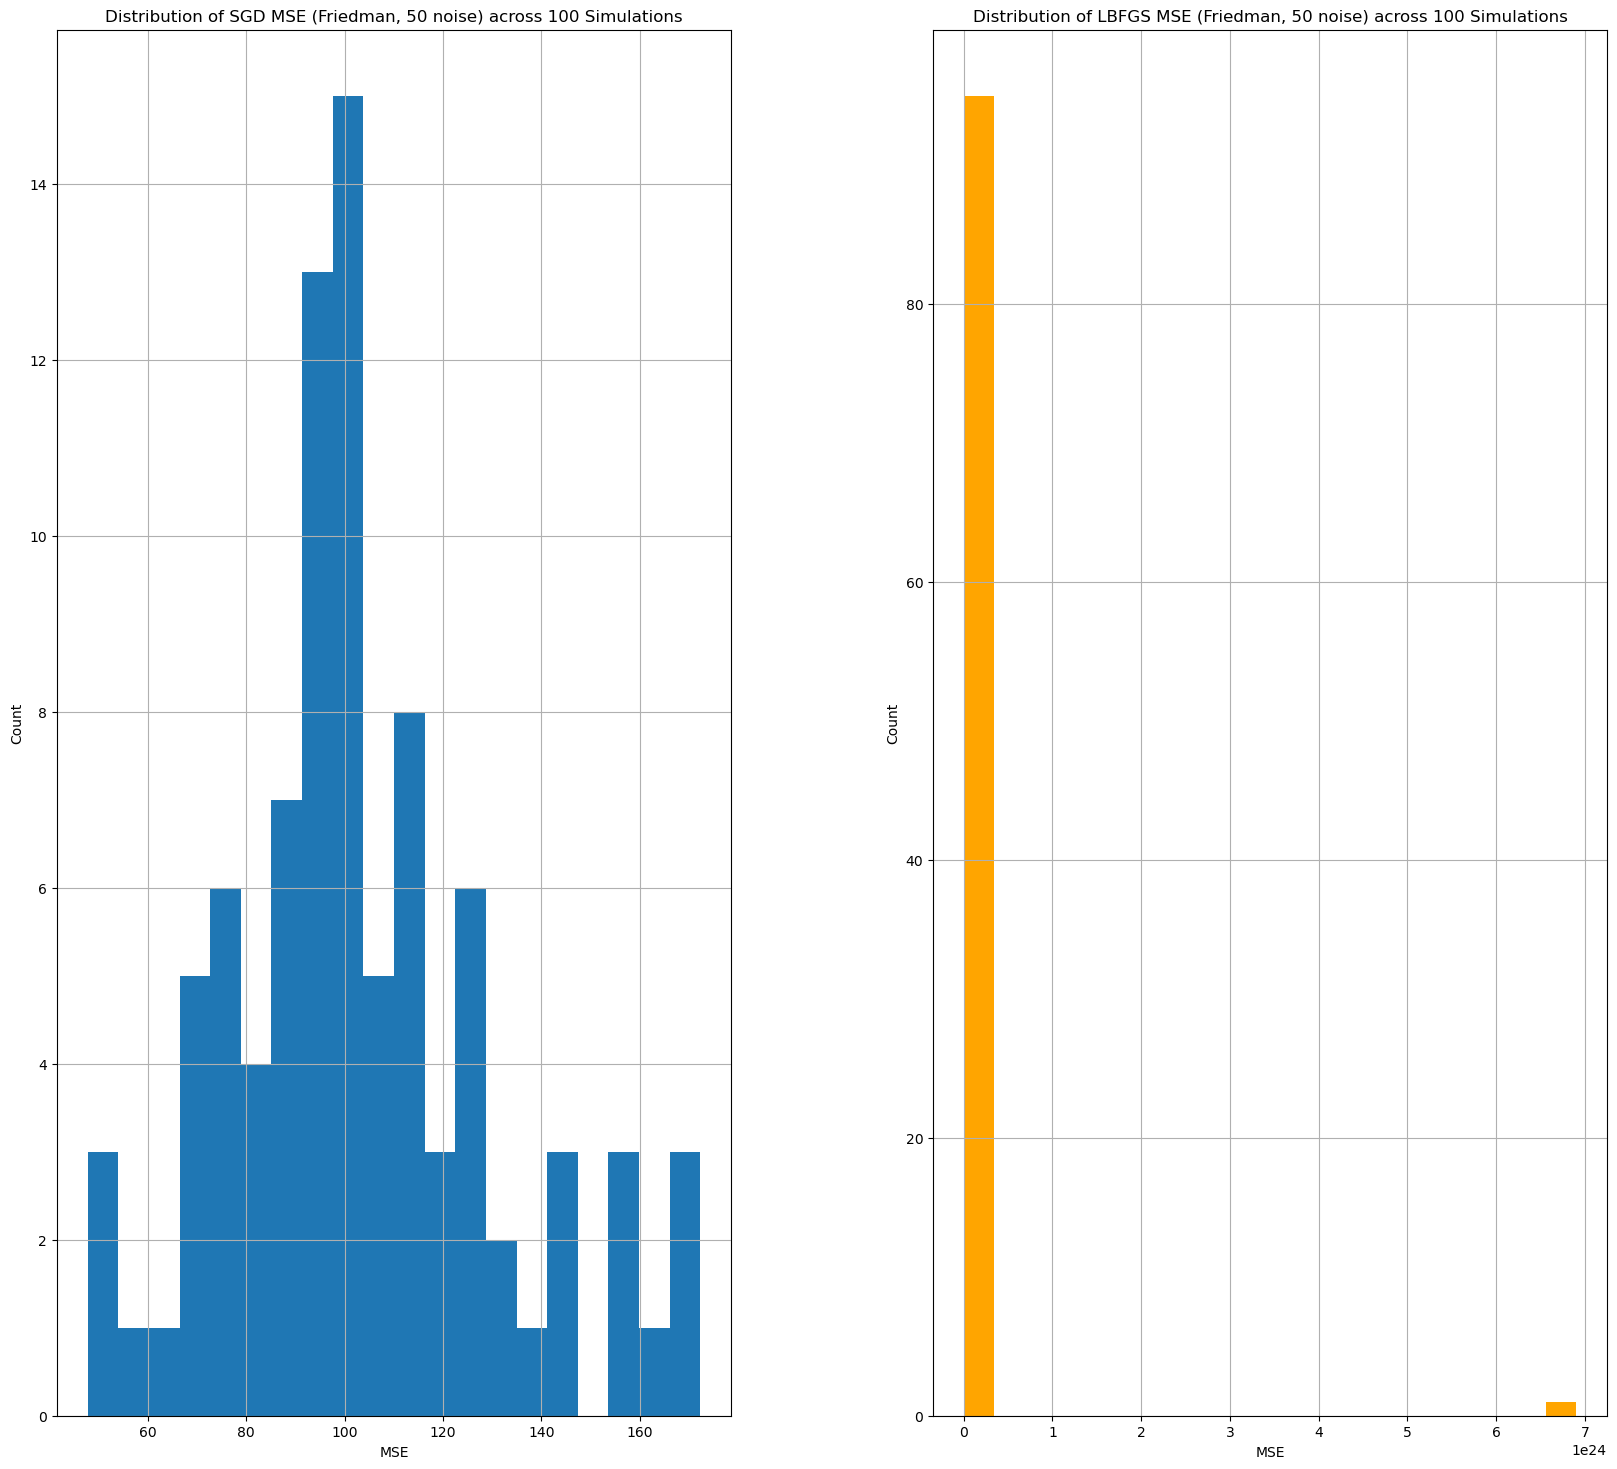

In [11]:
sgd_mse_df = pd.DataFrame(beta_mse['sgd'])
lbfgs_mse_df = pd.DataFrame(beta_mse['lbfgs'])
n = 2
fig, ax = plt.subplots(1, 2, figsize=(20, 18))
sgd_mse_df.hist(ax = ax[0],bins = 20)
ax[0].set_title('Distribution of SGD MSE (Friedman, '+str(noise)+' noise) across 100 Simulations')
ax[0].set_xlabel('MSE')
ax[0].set_ylabel('Count')
lbfgs_mse_df.hist(ax = ax[1], bins = 20, color = 'orange')
ax[1].set_title('Distribution of LBFGS MSE (Friedman, '+str(noise)+' noise) across 100 Simulations')
ax[1].set_xlabel('MSE')
ax[1].set_ylabel('Count')

## 100 noise

In [12]:
b = np.array([10,20,0.5,10,5]) # DO NOT CHANGE, THESE ARE TRUE BETAS 
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html
n_epochs = 250
n_sim = 100
noise = 100
# Track loss, beta error, and elapsed time
loss_history = {
    'sgd': np.zeros((n_sim, n_epochs)),
    'lbfgs': np.zeros((n_sim, n_epochs))
}

beta_mse = {
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}

elapsed_time = {
    'sgd': np.zeros(n_sim),
    'lbfgs': np.zeros(n_sim)
}



for i in tqdm(range(n_sim)): # 100 simulations take 6 minutes
    X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=noise, random_state=i)
    X_new = torch.tensor(X,requires_grad=True)
    y_new = torch.tensor(y,requires_grad=True)
    
    b_hat_sgd, loss_hist_sgd, elapsed_sgd = train_model(X_new, y_new, method='sgd', n_epochs=n_epochs)
    b_hat_lbfgs, loss_hist_lbfgs, elapsed_lbfgs = train_model(X_new, y_new, method='lbfgs', n_epochs=n_epochs)

    beta_mse['sgd'][i] = float(((b - np.array(b_hat_sgd))**2).mean())
    elapsed_time['sgd'][i] = elapsed_sgd
    loss_history['sgd'][i] = loss_hist_sgd
    
    beta_mse['lbfgs'][i] = float(((b - np.array(b_hat_lbfgs))**2).mean())
    elapsed_time['lbfgs'][i] = elapsed_lbfgs
    loss_history['lbfgs'][i] = loss_hist_lbfgs
save_data(n_sim,n_epochs,noise)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (s)')

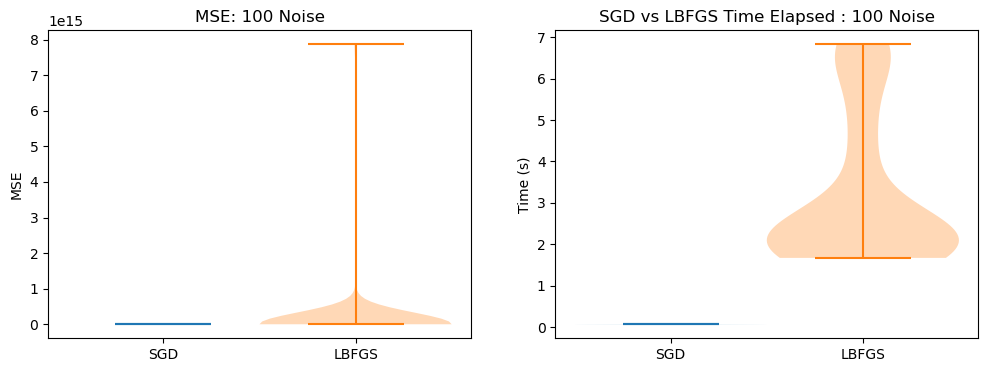

In [13]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
def get_finite_vals(array):
    ii = np.isfinite(array)
    return(array[ii])
    
axes[0].violinplot(get_finite_vals(beta_mse['sgd']))
axes[0].violinplot(get_finite_vals(beta_mse['lbfgs']), positions=[1.5])
    
axes[1].violinplot(get_finite_vals(elapsed_time['sgd']))
axes[1].violinplot(get_finite_vals(elapsed_time['lbfgs']), positions=[1.5])
    
axes[0].set_xticks([1, 1.5], ['SGD', 'LBFGS'])
axes[1].set_xticks([1, 1.5], ['SGD', 'LBFGS'])
    
axes[0].set_title(f'MSE: '+str(noise)+' Noise')
axes[1].set_title(f'SGD vs LBFGS Time Elapsed : '+str(noise)+' Noise')
    
axes[0].set_ylabel('MSE')
axes[1].set_ylabel('Time (s)')

Text(0, 0.5, 'Count')

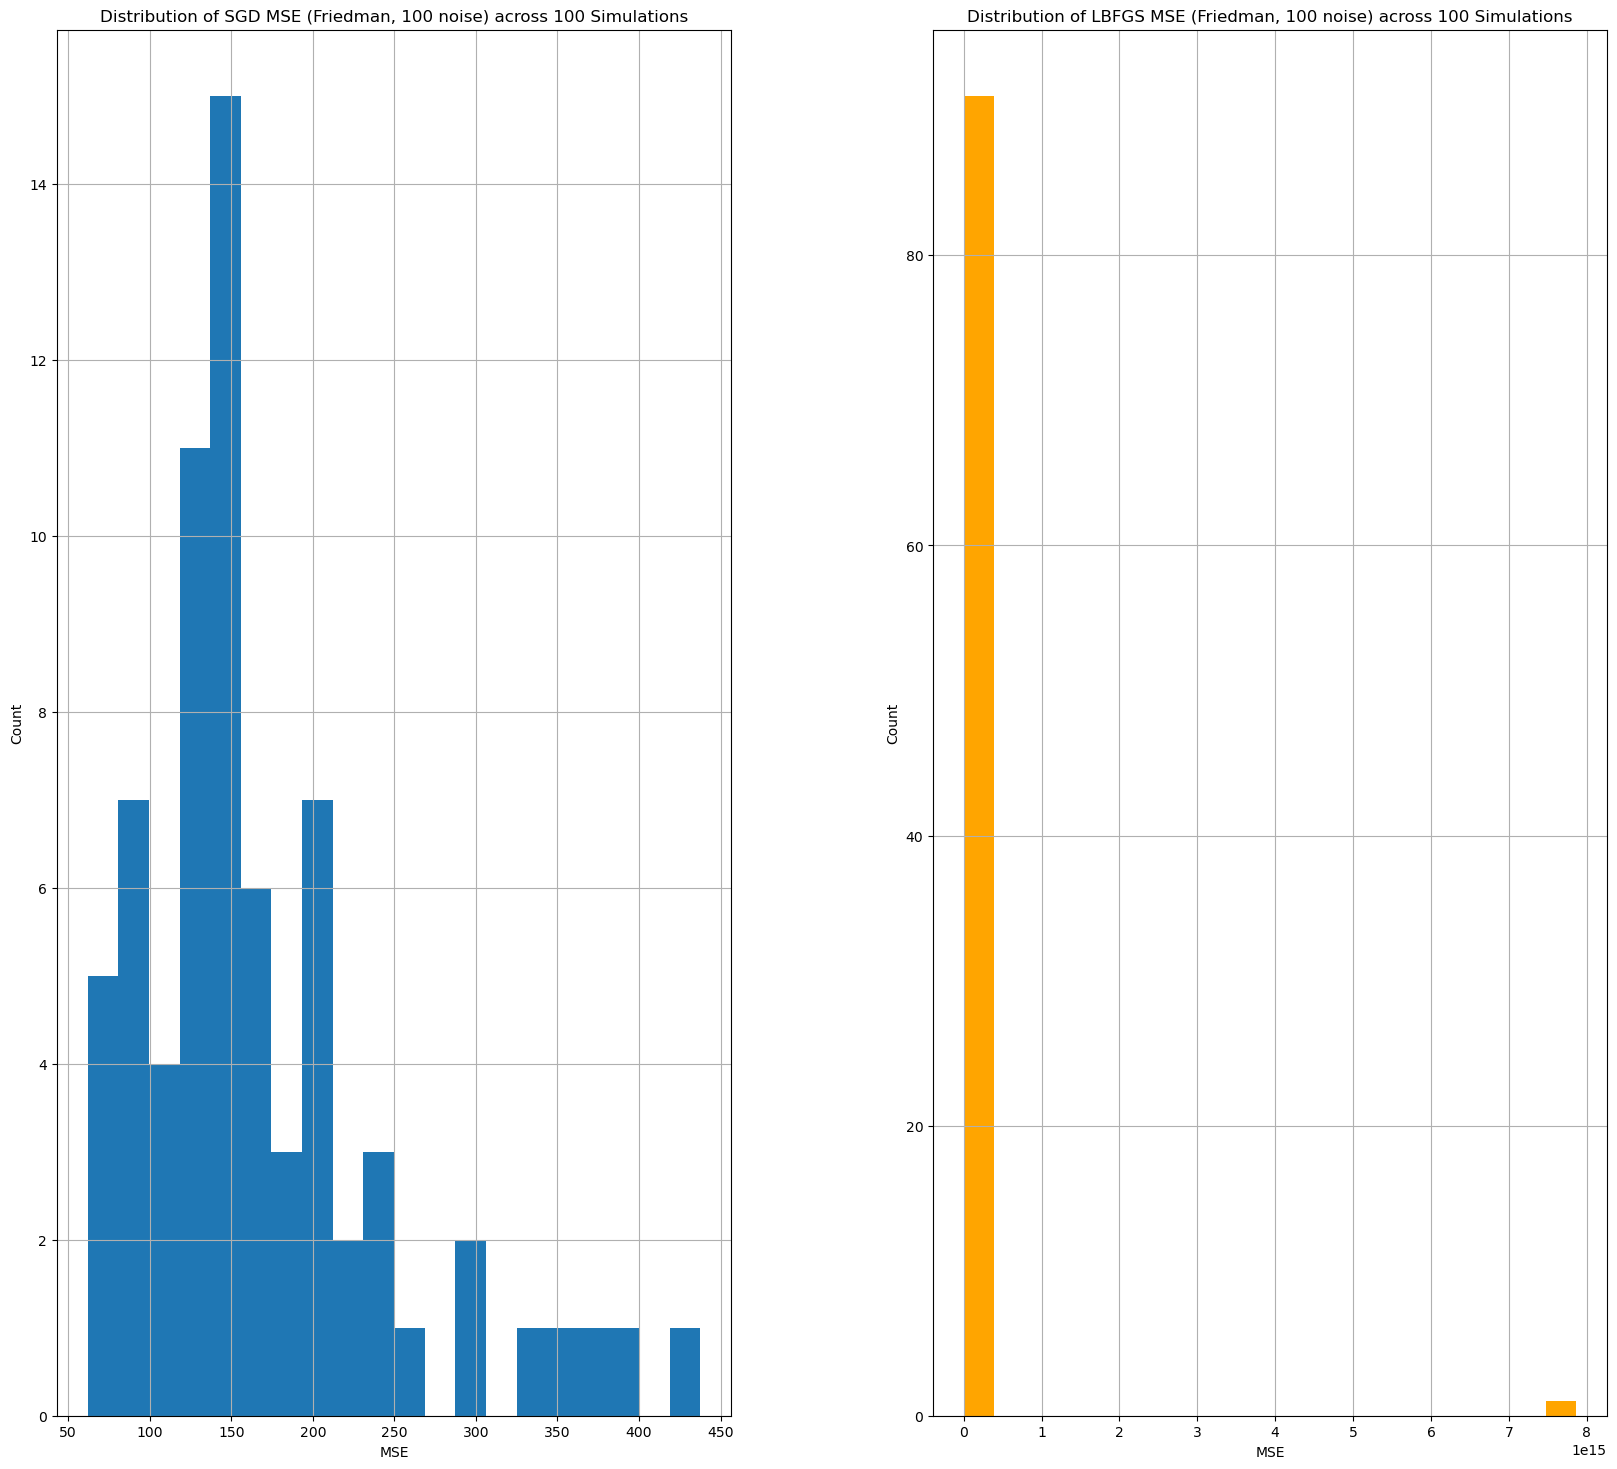

In [14]:
sgd_mse_df = pd.DataFrame(beta_mse['sgd'])
lbfgs_mse_df = pd.DataFrame(beta_mse['lbfgs'])
n = 2
fig, ax = plt.subplots(1, 2, figsize=(20, 18))
sgd_mse_df.hist(ax = ax[0],bins = 20)
ax[0].set_title('Distribution of SGD MSE (Friedman, '+str(noise)+' noise) across 100 Simulations')
ax[0].set_xlabel('MSE')
ax[0].set_ylabel('Count')
lbfgs_mse_df.hist(ax = ax[1], bins = 20, color = 'orange')
ax[1].set_title('Distribution of LBFGS MSE (Friedman, '+str(noise)+' noise) across 100 Simulations')
ax[1].set_xlabel('MSE')
ax[1].set_ylabel('Count')

The suprising thing here is that with hand calculations, you will get the wrong result. The LGBFS model is able to perform even with the noise and get the true $\beta$. The SGD algorithm is not able to discern it.

In [ ]:
X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=100, random_state=1)
X_new = torch.tensor(X,requires_grad=True)
y_new = torch.tensor(y,requires_grad=True)

In [60]:
b[0]*torch.sin(torch.pi*X_new[:,0]*X_new[:,1]) + b[1]*(X_new[:,2]-b[2])**2 + (b[3]*(X_new[:,3])) + (b[4]* X_new[:,4])

tensor([16.8522,  7.6788, 18.5132, 10.1642, 18.4880, 12.7059, 14.2817, 12.4647,
        16.6663, 13.9556,  7.1894, 12.8488,  6.4746, 21.3734, 16.4682, 16.2355,
        15.9705, 23.4023, 11.2311,  9.4540, 16.2431, 15.8937, 11.7828, 21.0780,
        11.2285, 13.0282, 14.0371, 18.1922,  7.6716,  7.3287,  5.5571, 18.4764,
        12.9969,  8.9521, 15.0198, 13.6190,  7.2838, 14.9575, 13.9113, 12.7325,
        21.7790, 21.8766, 13.3668, 12.7017, 14.3696, 25.7350, 14.1906,  8.8407,
        13.6356, 12.5458, 13.0784, 16.0904, 21.6017, 12.2113, 13.3658, 11.6325,
        10.4881, 21.0991, 15.9769, 15.0795, 15.1047, 13.8478,  8.2489, 17.5426,
        12.2305, 11.2761, 14.0120, 14.1483, 16.4412, 18.3260, 16.6881, 20.4431,
        14.8551, 15.1270, 10.2079, 16.9719, 15.2997,  8.9419,  9.1354, 17.5335,
        20.3746, 10.1675, 14.7885, 19.3692,  7.9534,  9.0812, 14.7350, 21.7548,
         5.0174, 13.3850, 20.3364, 12.2419, 12.2361, 16.1818, 18.5739,  6.6375,
        16.9439, 17.5579, 14.4053, 16.59

In [61]:
y_new

tensor([   5.2537,   -9.8670,  -74.8783,  -43.1379, -124.1676,  189.5019,
         -33.2556,   60.2257,  -85.5223,   93.4084, -180.1267,  104.9104,
           2.9378,  232.4339, -114.1852,   23.8736,   52.6937,  146.6923,
         -31.0546,   18.1004, -198.0035,  -67.1232,   56.9444,  131.4954,
         -16.9451,  218.6637,  190.0621,   12.1269, -233.6787, -170.4279,
         -72.2288,  130.0605,   44.0241, -200.4726,   -7.8568,  174.9551,
         -30.1967,  -60.0394,  219.3737,   18.0735,  -26.1367,   56.8934,
          15.0833,  -30.2126,  135.2153,  137.3052,   98.2768,   -1.4481,
         128.3257,    7.5755,   59.7427,  119.4591,  102.4862,  191.1868,
          58.4942, -156.7735, -105.5289,  156.1097,  -17.1514,   53.7334,
         -70.0409,  113.9359,  -30.2343,  163.3535,  -40.9929,  123.0895,
          81.4516,  -58.0909,  126.3409,  -71.8375,  -65.5586,   92.6143,
         -47.6791,  -44.2573,  -24.1821,  -83.0450,  119.7992,   69.7934,
           2.2026,    6.6943,   65.390

## Sanity Check

In [53]:
X,y = datasets.make_friedman1(n_samples=100, n_features=5, noise=0, random_state=1)
X_new = torch.tensor(X,requires_grad=True)
y_new = torch.tensor(y,requires_grad=True)

With 0 noise, it matches.

In [54]:

b[0]*torch.sin(torch.pi*X_new[:,0]*X_new[:,1]) + b[1]*(X_new[:,2]-b[2])**2 + (b[3]*(X_new[:,3])) + (b[4]* X_new[:,4])

tensor([16.8522,  7.6788, 18.5132, 10.1642, 18.4880, 12.7059, 14.2817, 12.4647,
        16.6663, 13.9556,  7.1894, 12.8488,  6.4746, 21.3734, 16.4682, 16.2355,
        15.9705, 23.4023, 11.2311,  9.4540, 16.2431, 15.8937, 11.7828, 21.0780,
        11.2285, 13.0282, 14.0371, 18.1922,  7.6716,  7.3287,  5.5571, 18.4764,
        12.9969,  8.9521, 15.0198, 13.6190,  7.2838, 14.9575, 13.9113, 12.7325,
        21.7790, 21.8766, 13.3668, 12.7017, 14.3696, 25.7350, 14.1906,  8.8407,
        13.6356, 12.5458, 13.0784, 16.0904, 21.6017, 12.2113, 13.3658, 11.6325,
        10.4881, 21.0991, 15.9769, 15.0795, 15.1047, 13.8478,  8.2489, 17.5426,
        12.2305, 11.2761, 14.0120, 14.1483, 16.4412, 18.3260, 16.6881, 20.4431,
        14.8551, 15.1270, 10.2079, 16.9719, 15.2997,  8.9419,  9.1354, 17.5335,
        20.3746, 10.1675, 14.7885, 19.3692,  7.9534,  9.0812, 14.7350, 21.7548,
         5.0174, 13.3850, 20.3364, 12.2419, 12.2361, 16.1818, 18.5739,  6.6375,
        16.9439, 17.5579, 14.4053, 16.59

In [56]:
y_new

tensor([16.8522,  7.6788, 18.5132, 10.1642, 18.4880, 12.7059, 14.2817, 12.4647,
        16.6663, 13.9556,  7.1894, 12.8488,  6.4746, 21.3734, 16.4682, 16.2355,
        15.9705, 23.4023, 11.2311,  9.4540, 16.2431, 15.8937, 11.7828, 21.0780,
        11.2285, 13.0282, 14.0371, 18.1922,  7.6716,  7.3287,  5.5571, 18.4764,
        12.9969,  8.9521, 15.0198, 13.6190,  7.2838, 14.9575, 13.9113, 12.7325,
        21.7790, 21.8766, 13.3668, 12.7017, 14.3696, 25.7350, 14.1906,  8.8407,
        13.6356, 12.5458, 13.0784, 16.0904, 21.6017, 12.2113, 13.3658, 11.6325,
        10.4881, 21.0991, 15.9769, 15.0795, 15.1047, 13.8478,  8.2489, 17.5426,
        12.2305, 11.2761, 14.0120, 14.1483, 16.4412, 18.3260, 16.6881, 20.4431,
        14.8551, 15.1270, 10.2079, 16.9719, 15.2997,  8.9419,  9.1354, 17.5335,
        20.3746, 10.1675, 14.7885, 19.3692,  7.9534,  9.0812, 14.7350, 21.7548,
         5.0174, 13.3850, 20.3364, 12.2419, 12.2361, 16.1818, 18.5739,  6.6375,
        16.9439, 17.5579, 14.4053, 16.59